In [1]:
from matplotlib import pyplot as plt

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import transform_matrix, Quaternion

import numpy as np

from PIL import Image
from skimage.draw import polygon
import os

%matplotlib inline

In [2]:
data_root = '/home/lemondrok/programming/kursa4/data/datasets/nuscenesmini/v1.0-mini/'
nusc = NuScenes(version='v1.0-mini', dataroot=data_root, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.396 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [122]:
def abs2ego(ego_pose, cam_pose, annotation_data):
    occ_width, occ_height = 256, 256
    scale = 4
    
    ego2cam = transform_matrix(cam_pose['translation'], Quaternion(cam_pose['rotation']), inverse=True)
    world2ego = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=True)
    world2cam = np.dot(ego2cam, world2ego)
    
    obj2world = transform_matrix(annotation_data['translation'], Quaternion(annotation_data['rotation']), inverse=False)
    obj2cam = np.dot(world2cam, obj2world)
            
    
    vehicle_first_edge = annotation_data['size'].copy()
    vehicle_first_edge = [x / 2 for x in vehicle_first_edge]
    vehicle_first_edge[1], vehicle_first_edge[0] = vehicle_first_edge[0], vehicle_first_edge[1]
    
    vehicle_second_edge = vehicle_first_edge.copy()
    vehicle_second_edge[1] *= -1
    vehicle_third_edge = [-x for x in vehicle_first_edge]
    vehicle_fourth_edge = [-x for x in vehicle_second_edge]

    first_edge = np.dot(obj2cam, vehicle_first_edge + [1])    
    second_edge = np.dot(obj2cam, vehicle_second_edge + [1])
    third_edge = np.dot(obj2cam, vehicle_third_edge + [1])
    fourth_edge = np.dot(obj2cam, vehicle_fourth_edge + [1])    
        
    polygons = []
    polygons.append(first_edge)
    polygons.append(second_edge)
    polygons.append(third_edge)
    polygons.append(fourth_edge)
    
    polygons = np.array(polygons)
    
#     print(center)
#     print(polygons)
#     print(occ_width - scale * polygons[:, 2])
#     print(occ_width / 2 + scale * polygons[:, 0])

    rr, cc = polygon(
        occ_width - scale * polygons[:, 2], occ_width / 2 + scale * polygons[:, 0], (occ_width, occ_height)
    )
    ans = np.zeros((occ_width, occ_height), dtype='uint8')
    ans[rr, cc] = 255
    return ans

[ 6.24948615  0.31863358 35.39441124  1.        ]
[[ 5.56126449 -0.54413965 37.4429118   1.        ]
 [ 7.26435614 -0.50446111 37.31975154  1.        ]
 [ 6.9377078   1.18140681 33.34591068  1.        ]
 [ 5.23461615  1.14172826 33.46907093  1.        ]]
[106.2283528  106.72099383 122.61635729 122.12371626]
[150.24505796 157.05742455 155.75083121 148.93846462]


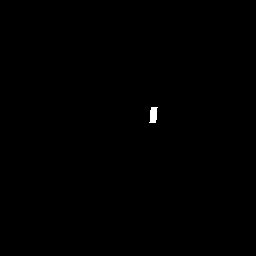

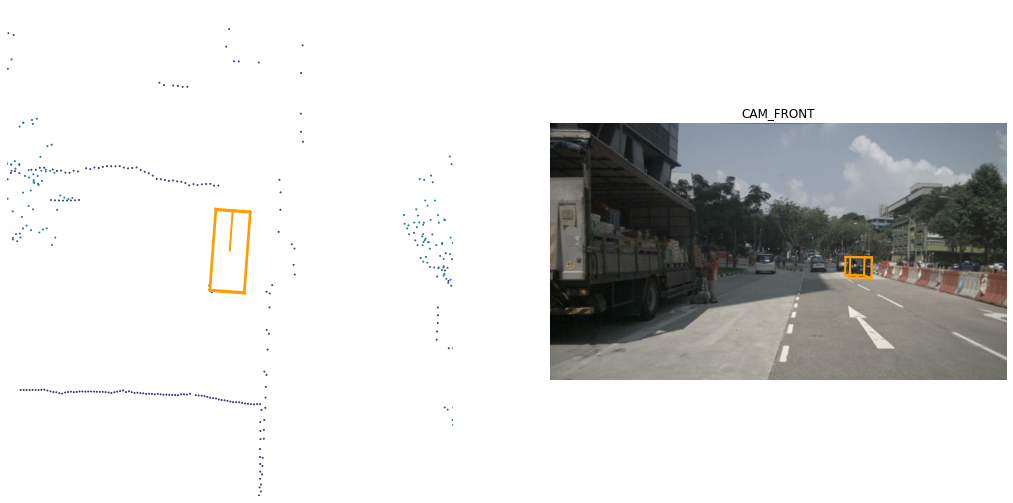

In [119]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', nusc.get('sample', 'ca9a282c9e77460f8360f564131a8af5')['data'][sensor])
front_ego_pose = nusc.get('ego_pose', cam_front_data['ego_pose_token'])
cam_pose = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
annotation = 'a286c9633fa34da5b978758f348996b0'
# annotation = '924ee6ac1fed440a9d9e3720aac635a0'
# annotation = '83d881a6b3d94ef3a3bc3b585cc514f8'
# annotation = '16140fbf143d4e26a4a7613cbd3aa0e8'
# annotation = 'cda0a9085607438c9b1ea87f4360dd64'
# annotation = 'a6f7d4bb60374f868144c5ba4431bf4c'
# annotation = 'b7cbc6d0e80e4dfda7164871ece6cb71'
# annotation = '49f76277d07541c5a584aa14c9d28754'
annotation_metadata = nusc.get('sample_annotation', annotation)
nusc.render_annotation(annotation)
Image.fromarray(abs2ego(front_ego_pose, cam_pose, annotation_metadata))


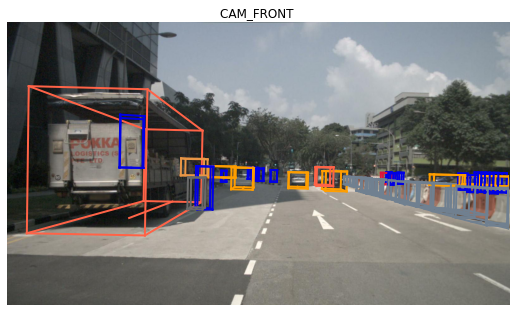

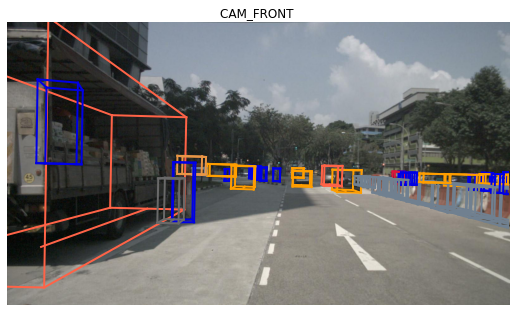

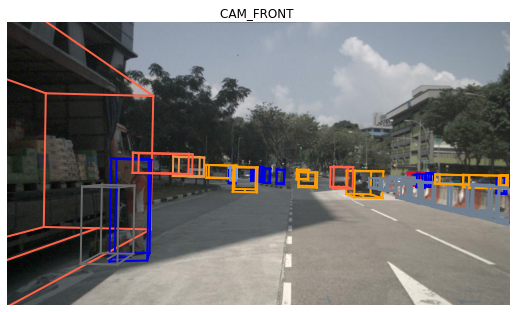

In [129]:
occ_width, occ_height = 256, 256
sensor = 'CAM_FRONT'
output_dir = f'{data_root}/gt'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
counter = 3
for sample in nusc.sample:
    my_sample = nusc.get('sample', sample['token'])
    new_pic = np.zeros((occ_width, occ_height), dtype=np.uint8)
    new_pic.fill(0)
    cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
    ego_pose = nusc.get('ego_pose', cam_front_data['ego_pose_token'])
    cam_pose = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
    nusc.render_sample_data(my_sample['data']['CAM_FRONT'])
    
    for annotation in my_sample['anns']:
        annotation_metadata = nusc.get('sample_annotation', annotation)
        if int(annotation_metadata['visibility_token']) > 2 and annotation_metadata['category_name'].split('.')[0] == 'vehicle':
            new_pic += abs2ego(ego_pose, cam_pose, annotation_metadata)
            
    img = Image.fromarray(new_pic)
    img.show()
    Image.fromarray(new_pic).show()
    counter -= 1
    
    if counter == 0:
        break


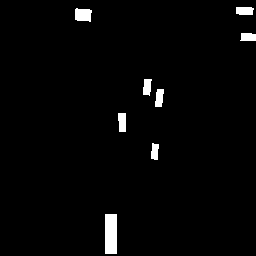

In [130]:
img